In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [101]:
class Gaussian_1d(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian_1d, self).__init__()
        self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))
        self.sigma = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))

    def forward(self, x):
        diff = x - self.mu
        return -0.5 * (diff**2/self.sigma**2)

In [71]:
def compute_psi_1d(x, model):
    x.requires_grad_()
    nn_output = model(x)
    psi = torch.autograd.grad(nn_output, x, create_graph=True)[0]
    return psi

In [72]:
def J_1d(x_t, model):
    T = len(x_t)
    total_sum = 0
    # norm_squared_list, norm_squared_real_list = [], []

    for t in range(T):
        x = x_t[t]
        psi_x_t = compute_psi_1d(x, model)

        divergence = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
        norm_squared = (psi_x_t ** 2).sum()

        # Accumulate sum
        total_sum += 0.5 * norm_squared + divergence

    return total_sum / T

In [92]:
def optimize_theta_gaussian_1d(
        x_t_all, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_sigma=1e-4, clip_value=1.0,
    ):
    model = Gaussian_1d(dim)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.sigma], "lr": learning_rate_sigma},
        ]
    )
    losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t_all, dtype=torch.float64)
        loss = J_1d(x_t_tensor, model)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        print(f"Epoch {epoch}, mu: {model.mu}")
        print(f"Epoch {epoch}, sigma: {model.sigma}")
        losses.append(loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append(model.sigma.detach().numpy().copy())

        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, estimated_mus, estimated_covs

In [102]:
x = torch.randn(1000)

In [94]:
epochs = 100
model, losses, estimated_mus, estimated_covs = optimize_theta_gaussian_1d(x, 1, num_epochs=epochs, learning_rate_mu=5e-3)

C:\Users\79217\AppData\Local\Temp\ipykernel_11324\1299025291.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_t_tensor = torch.tensor(x_t_all, dtype=torch.float64)


Epoch 0, mu: Parameter containing:
tensor([-1.5642], dtype=torch.float64, requires_grad=True)
Epoch 0, sigma: Parameter containing:
tensor([1.4041], dtype=torch.float64, requires_grad=True)
Epoch 0/100, Loss: -0.06511000819651616
Epoch 1, mu: Parameter containing:
tensor([-1.5582], dtype=torch.float64, requires_grad=True)
Epoch 1, sigma: Parameter containing:
tensor([1.4042], dtype=torch.float64, requires_grad=True)
Epoch 1/100, Loss: -0.06715421014900069
Epoch 2, mu: Parameter containing:
tensor([-1.5510], dtype=torch.float64, requires_grad=True)
Epoch 2, sigma: Parameter containing:
tensor([1.4043], dtype=torch.float64, requires_grad=True)
Epoch 2/100, Loss: -0.06959722894534631
Epoch 3, mu: Parameter containing:
tensor([-1.5423], dtype=torch.float64, requires_grad=True)
Epoch 3, sigma: Parameter containing:
tensor([1.4045], dtype=torch.float64, requires_grad=True)
Epoch 3/100, Loss: -0.07251443169466457
Epoch 4, mu: Parameter containing:
tensor([-1.5320], dtype=torch.float64, requir

In [96]:
print("Final estimated μ:", estimated_mus[-1][0])
print("True μ:", 0)
print("\nFinal estimated Σ:\n", estimated_covs[-1][0])
print("True Σ:\n", 1)

Final estimated μ: -0.019441836363221433
True μ: 0

Final estimated Σ:
 1.0172007843152728
True Σ:
 1


In [158]:
class Gaussian(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian, self).__init__()
        # self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))
        # self.L = nn.Parameter(torch.randn(size=[dimensions, dimensions], dtype=torch.float64))
        self.mu = nn.Parameter(torch.tensor([0.0] * dimensions, dtype=torch.float64))
        self.L = nn.Parameter(torch.eye(dimensions, dtype=torch.float64))

    def forward(self, x):
        cov = self.L @ self.L.T
        cov_inv = torch.cholesky_inverse(torch.linalg.cholesky(cov))
        diff = x - self.mu
        return -0.5 * (diff.T @ cov_inv @ diff)

In [130]:
def compute_psi(x, model):
    nn_output = model(x)
    psi = torch.autograd.grad(nn_output, x, create_graph=True)[0]
    return psi

def compute_psi_wrapped(x):
    return compute_psi(x, model)

In [137]:
def compute_divergence_jacobian(x, model):
    jacobian = torch.autograd.functional.jacobian(lambda x: compute_psi(x, model), x)
    divergence = jacobian.diagonal(dim1=-2, dim2=-1).sum(-1)  # Sum diagonal elements
    return divergence

In [75]:
def gaussian_psi(x, mu=torch.tensor([0.0, 0.0]), cov=torch.eye(2, dtype=torch.float64)):
    return -torch.cholesky_inverse(torch.linalg.cholesky(cov)) @ (x - mu)

In [76]:
def gaussian_J(x_t, mu=torch.tensor([0.0, 0.0]), L=torch.eye(2, dtype=torch.float32)):
    cov = L @ L.T
    cov_inv = torch.cholesky_inverse(torch.linalg.cholesky(cov))
    diff = x_t - mu
    trace_term = -torch.trace(cov_inv)
    quadratic_term = diff.T @ cov_inv @ cov_inv @ diff
    return trace_term, quadratic_term

In [77]:
def plot_norm_squared(norm_squared_list, norm_squared_real_list):
    plt.figure(figsize=(10, 5))
    
    # Norm squared plot
    plt.plot(norm_squared_list, label="norm_squared (Calculated)", marker='o')
    plt.plot(norm_squared_real_list, label="norm_squared_real (True)", marker='x')
    plt.xlabel("Time step t")
    plt.ylabel("Norm Squared")
    plt.title("Norm Squared Comparison")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [138]:
def J(x_t, model):
    T = len(x_t)
    total_sum, real_sum = 0, 0
    # norm_squared_list, norm_squared_real_list = [], []

    for t in range(T):
        x = x_t[t]
        x.requires_grad_()
        psi_x_t = compute_psi(x, model)
        
        psi_x_t_real = gaussian_psi(x, model.mu.detach(), model.L.detach() @ model.L.T.detach())
        if not torch.allclose(psi_x_t, psi_x_t_real, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {psi_x_t} \
                is different from the analytical solution {psi_x_t_real}"
                )
        
        # divergence = torch.autograd.grad(psi_x_t.sum(), x, create_graph=True)[0].sum()
        divergence = compute_divergence_jacobian(x, model)
        norm_squared = (psi_x_t ** 2).sum()
        # divergence = torch.autograd.grad(psi_x_t_real.sum(), x, create_graph=True)[0].sum()
        # norm_squared = (psi_x_t_real ** 2).sum()
        
        divergence_real, norm_squared_real = gaussian_J(x, model.mu.detach(), model.L.detach())

        if not torch.allclose(divergence, divergence_real, atol=1e-2):
            raise ValueError(
                f"Calculated divergence value {divergence} \
                is different from the analytical solution {divergence_real}"
                )
        if not torch.allclose(norm_squared, norm_squared_real, atol=1e-2):
            raise ValueError(
                f"Calculated norm squared value {norm_squared} \
                is different from the analytical solution {norm_squared_real}"
                )
        
        # Collect data for plotting
        # norm_squared_list.append(norm_squared.detach().item())
        # norm_squared_real_list.append(norm_squared_real.detach().item())

        # Accumulate sums
        real_sum += 0.5 * norm_squared_real + divergence_real
        total_sum += 0.5 * norm_squared + divergence

    # print(f"Divergence (autograd): {divergence}")
    # print(f"Divergence (analytical): {divergence_real}")

    # plot_norm_squared(norm_squared_list, norm_squared_real_list)
    # plot_psi(psi, real_psi)

    return total_sum / T, real_sum / T

In [141]:
def optimize_theta_gaussian(
        x_t_all, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_L=1e-4, l2_reg=1e-4, clip_value=1.0,
    ):
    model = Gaussian(dim)
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.L], "lr": learning_rate_L},
        ]
    )
    losses = []
    real_losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = torch.tensor(x_t_all, dtype=torch.float64)
        loss, real_loss = J(x_t_tensor, model)

        l2_loss = sum((param ** 2).sum() for param in model.parameters())
        loss += l2_reg * l2_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        # print(f"Epoch {epoch}, mu: {model.mu}")
        # print(f"Epoch {epoch}, cov: {model.L @ model.L.T}")
        optimizer.step()

        losses.append(loss.item())
        real_losses.append(real_loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_covs.append((model.L).detach().numpy().copy())

        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, real_losses, estimated_mus, estimated_covs

In [13]:
def generate_multivariate_gaussian_data(mean, cov, num_samples):
    np.random.seed(123)
    data = np.random.multivariate_normal(mean, cov, num_samples)
    return data

In [159]:
n = 100
mu = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])
x_t_all = generate_multivariate_gaussian_data(mu, cov, n)
dim = x_t_all.shape[1]

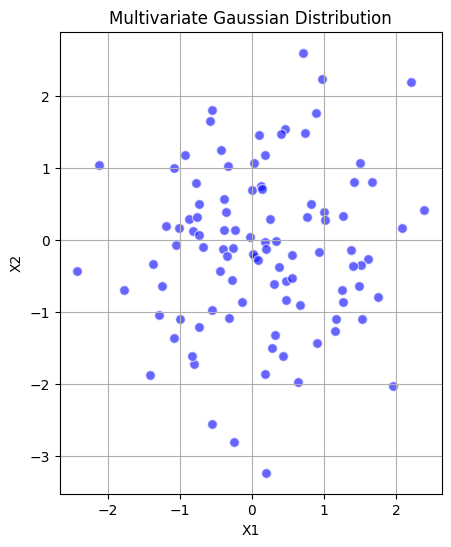

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [160]:
epochs = 100
model, losses, real_losses, estimated_mus, estimated_covs = optimize_theta_gaussian(
    x_t_all, dim, num_epochs=epochs, learning_rate_mu=1e-3, learning_rate_L= 1e-5
    )

Epoch 0/100, Loss: -0.8922764680782923
Epoch 1/100, Loss: -0.8925366327399304
Epoch 2/100, Loss: -0.8928461867695848
Epoch 3/100, Loss: -0.8932138448734208
Epoch 4/100, Loss: -0.8936495529057857
Epoch 5/100, Loss: -0.8941645089103625
Epoch 6/100, Loss: -0.8947710892869405
Epoch 7/100, Loss: -0.8954826175128383
Epoch 8/100, Loss: -0.8963128811516766
Epoch 9/100, Loss: -0.8972752564066487
Epoch 10/100, Loss: -0.8983812315512203
Epoch 11/100, Loss: -0.8996380215602519
Epoch 12/100, Loss: -0.9010448222515928
Epoch 13/100, Loss: -0.9025870431436274
Epoch 14/100, Loss: -0.9042275550534142
Epoch 15/100, Loss: -0.9058935493967069
Epoch 16/100, Loss: -0.907456970922683
Epoch 17/100, Loss: -0.9087055673186787
Epoch 18/100, Loss: -0.9093002724963372
Epoch 19/100, Loss: -0.909197173040207
Epoch 20/100, Loss: -0.9094029183895155
Epoch 21/100, Loss: -0.909880896455168
Epoch 22/100, Loss: -0.9102368662969087
Epoch 23/100, Loss: -0.9105695255209244
Epoch 24/100, Loss: -0.9109904845111202
Epoch 25/100,

In [ ]:
os.makedirs('data', exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

losses_file = f"data/run_{timestamp}_losses_epoch_{epochs}.npy"
mus_file = f"data/run_{timestamp}_mus_epoch_{epochs}.npy"
covs_file = f"data/run_{timestamp}_covs_epoch_{epochs}.npy"

np.save(losses_file, losses)
np.save(mus_file, estimated_mus)
np.save(covs_file, estimated_covs)

print(f"Saved files: {losses_file}, {mus_file}, {covs_file}")

Saved files: data/run_20241121_153011_losses_epoch_100.npy, data/run_20241121_153011_mus_epoch_100.npy, data/run_20241121_153011_covs_epoch_100.npy


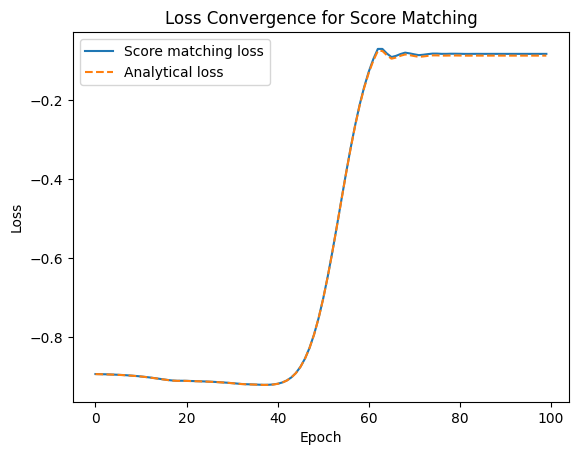

In [161]:
plt.plot(losses, label="Score matching loss")
plt.plot(real_losses, label="Analytical loss", linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()

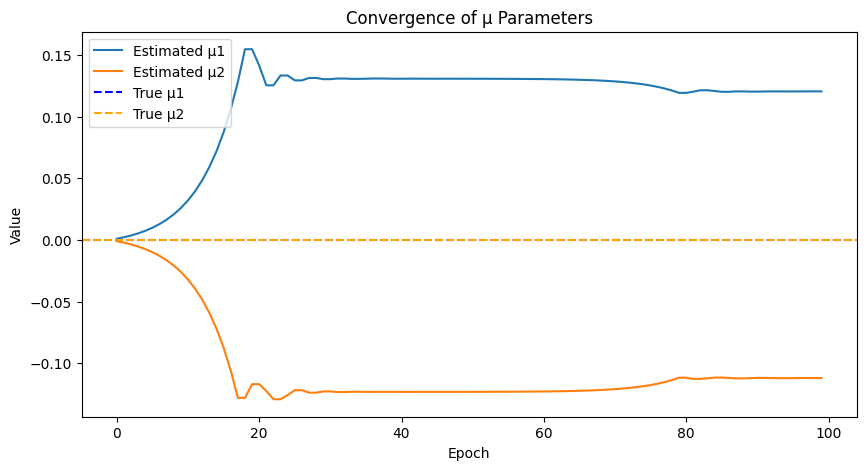

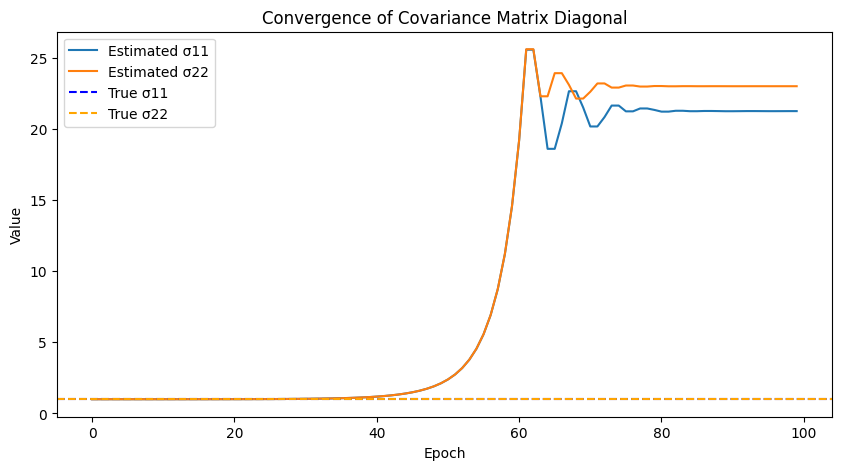

In [162]:
estimated_mus = np.array(estimated_mus)
plt.figure(figsize=(10, 5))
plt.plot(estimated_mus[:, 0], label="Estimated μ1")
plt.plot(estimated_mus[:, 1], label="Estimated μ2")
plt.axhline(mu[0], color='blue', linestyle='--', label="True μ1")
plt.axhline(mu[1], color='orange', linestyle='--', label="True μ2")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ Parameters')
plt.show()

# Plot convergence of covariance matrix diagonal (variance terms)
estimated_covs_diag = np.array([np.diag(cov @ cov.T) for cov in estimated_covs])
plt.figure(figsize=(10, 5))
plt.plot(estimated_covs_diag[:, 0], label="Estimated σ11")
plt.plot(estimated_covs_diag[:, 1], label="Estimated σ22")
plt.axhline(cov[0, 0], color='blue', linestyle='--', label="True σ11")
plt.axhline(cov[1, 1], color='orange', linestyle='--', label="True σ22")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of Covariance Matrix Diagonal')
plt.show()

In [163]:
print("Final estimated μ:", estimated_mus[-1])
print("True μ:", mu)
print("\nFinal estimated Σ:\n", estimated_covs[-1])
print("True Σ:\n", cov)

Final estimated μ: [ 0.12052764 -0.11204989]
True μ: [0. 0.]

Final estimated Σ:
 [[ 4.61029024 -0.05909184]
 [ 0.18478329  4.79320722]]
True Σ:
 [[1. 0.]
 [0. 1.]]


In [150]:
model_mu = torch.tensor(estimated_mus[-1])
model_cov = torch.tensor(estimated_covs[-1]) @ torch.tensor(estimated_covs[-1]).T
model_x_t = generate_multivariate_gaussian_data(model_mu, model_cov, n)

C:\Users\79217\AppData\Local\Temp\ipykernel_11324\2233108499.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.random.multivariate_normal(mean, cov, num_samples)


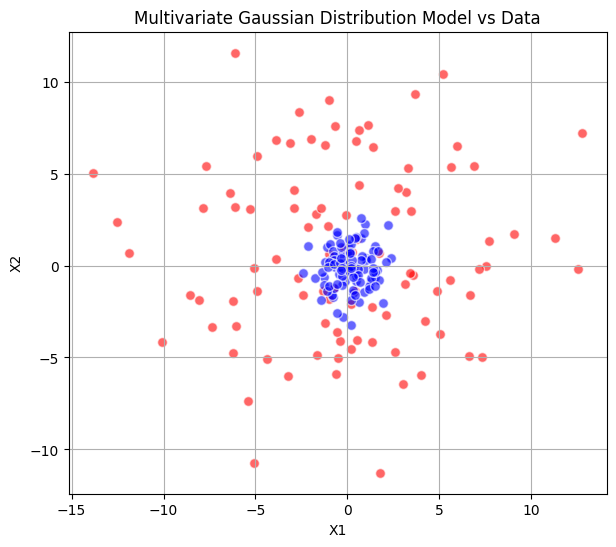

In [151]:
plt.figure(figsize=(8, 6))
plt.scatter(model_x_t[:, 0], model_x_t[:, 1], c='red', alpha=0.6, edgecolors='w', s=50)

plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution Model vs Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()